### We'll try to finetune resnet on herbarium dataset then use it to train the prototype networks

In [1]:
from fastai import *
from fastai.vision import *
import random
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

In [2]:
#os.environ['CUDA_VISIBLE_DEVICES']=''

In [3]:
torch.cuda.set_device(3)

In [4]:
import os 
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
#os.environ['CUDA_VISIBLE_DEVICES']='3'
os.environ['OMP_NUM_THREADS'] = '8'
os.environ['MKL_NUM_THREADS'] = '8'
os.environ['http_proxy'] = "http://proxy.hcm.fpt.vn:80/"
os.environ['https_proxy'] = "https://proxy.hcm.fpt.vn:80/"

In [5]:
os.environ['TORCH_HOME'] = '/bigdata/user/hieunt124/models/'

In [6]:
from datetime import datetime

In [7]:
import numpy as np                                    # Array, Linear Algebra
from torch.utils.data.dataset import random_split     # spliting inTrain Val
import pandas as pd                                   # handling CSV
import os                                             # For File handling
import random                                         # Choosing from images dataset
import time                                           # timing Epochs  
from tqdm.notebook import tqdm                        # Testing
from os.path import join                              # File Handling
from torchvision import transforms                    # Data Aug
import torch                                          # Framework
from PIL import Image                                 # Loading Image
from torch.utils.data import Dataset, DataLoader      # Dataset
import torch.nn.functional as F                       # Function
import json                                           # Loading Metadat
from PIL import  ImageOps                             # Data Aug 
from PIL.Image import open as openIm                  # Image Handling
import matplotlib.pyplot  as plt                      # Ploting Image
import cv2
from sklearn.metrics import f1_score
import seaborn as sns

Include the following line to import the functions from few_shot

In [8]:
import sys
sys.path.append('/bigdata/user/hieunt124/submodules/few_shot/')


In [9]:
"""
Reproduce Omniglot results of Snell et al Prototypical networks.
"""
from torch.optim import Adam
from torch.utils.data import DataLoader
import argparse

from few_shot.datasets import OmniglotDataset, MiniImageNet
from few_shot.models import get_few_shot_encoder
from few_shot.core import NShotTaskSampler, EvaluateFewShot, prepare_nshot_task
from few_shot.proto import proto_net_episode
from few_shot.train import fit
from few_shot.callbacks import *
from few_shot.utils import setup_dirs
from config import PATH


In [10]:
'''
import vision stuff
'''
import torchvision
import torch.nn as nn

In [11]:
#torch.set_num_threads(3)

In [12]:
base_dir = '/bigdata/user/hieunt124/kaggle/herbarium/'
train_dir = base_dir + '/nybg2020/train/'
test_dir = base_dir + '/nybg2020/test/'
metadata_file = 'metadata.json'

In [13]:

with open(train_dir + metadata_file, encoding = "ISO-8859-1") as json_file:
    train_metadata = json.load(json_file)

train_img = pd.DataFrame(train_metadata['images'])
train_label = pd.DataFrame(train_metadata['annotations'])
train_df = (pd.merge(train_label, train_img
                    #, left_on='image_id'
                    , on='id'
                    , how='left')
            .drop(['image_id', 'license', 'region_id'], axis=1)
            .sort_values(by=['category_id'])
           )
train_df.head()

,category_id,id,file_name,height,width
76407,0,626762,images/000/00/626762.jpg,1000,681
601590,0,72077,images/000/00/72077.jpg,1000,681
76408,0,818271,images/000/00/818271.jpg,1000,681
556748,0,495523,images/000/00/495523.jpg,1000,681
335261,0,437000,images/000/00/437000.jpg,1000,681


In [14]:
train_df.rename(columns={'category_id': 'class_id'
                        , 'file_name': 'filepath'
                        }, inplace=True)

In [15]:
high_samples_classes = train_df.class_id.value_counts()[:200].index.tolist()

I'm not sure how to work with this yet. Let's first try classifying with data of reasonable numbers of samples. See where performance is at.

In [16]:
train_dir

'/bigdata/user/hieunt124/kaggle/herbarium//nybg2020/train/'

In [17]:
#temp_filter = (train_df.class_id.isin(list(train_df.class_id.unique()[500:1000])))
temp_filter = (train_df.class_id.isin(high_samples_classes))
source = ImageList.from_df(train_df[temp_filter]
                           , train_dir
                           , cols='filepath'
                           #, 
                          )

In [18]:
train_df[temp_filter].shape

(111619, 5)

In [19]:
source = (source
 .split_by_rand_pct(0.2)
 .label_from_df(cols='class_id')
)

In [20]:
transforms = get_transforms(flip_vert=True
                            #, max_lighting=.1
                            #, max_zoom=1.05
                            #, max_warp=0.
                           )

In [21]:
data = (source
        .transform(tfms=transforms, size=256)
        .databunch(bs=32, num_workers=0)
        .normalize(imagenet_stats))

In [22]:
data.__len__()

2790

In [23]:
data.c

200

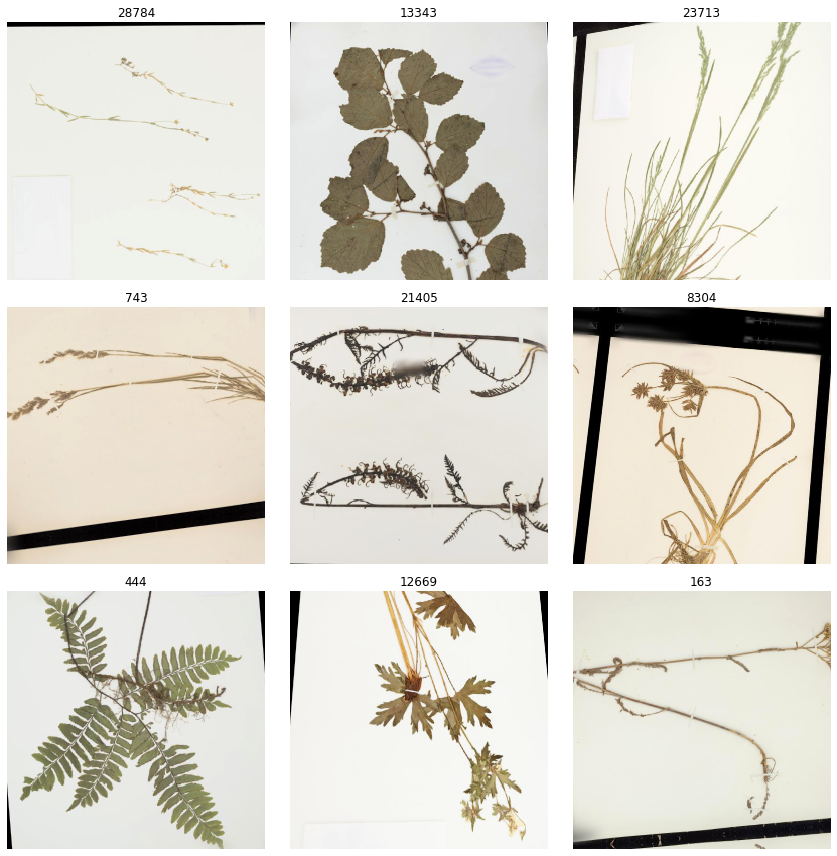

In [24]:
data.show_batch(3)

#### demo modelling

In [25]:
from efficientnet_pytorch import EfficientNet
from torchsummary import summary
from torch.nn.modules import Dropout

In [26]:
from fastai.layers import Flatten, AdaptiveConcatPool2d
def my_head(input_size, hidden_units, output_size):
        return nn.Sequential(AdaptiveConcatPool2d()
                                        , Flatten()
                                        , nn.BatchNorm1d(num_features=2 * input_size)
                                        , nn.Dropout(p=.25)
                                        , nn.Linear(in_features=2 * input_size, out_features=hidden_units, bias=True)
                                        , nn.ReLU(inplace=True)
                                        , nn.BatchNorm1d(num_features=hidden_units)
                                        , nn.Dropout(p=.5)
                                        , nn.Linear(in_features=hidden_units, out_features=output_size, bias=True)
                                        
                                       )

In [27]:
from pretrainedmodels import se_resnext50_32x4d, se_resnet101

In [28]:
#arch = se_resnext50_32x4d(pretrained='imagenet')
arch = se_resnet101(pretrained='imagenet')

In [29]:
arch = list(arch.children())
arch.pop(-1)
arch.pop(-1)
temp_arch = nn.Sequential(nn.Sequential(*arch))
temp_children = list(temp_arch.children())
temp_children.append(my_head(2048, 512, 200))
model = nn.Sequential(*temp_children)

In [30]:
for param in (list(model.parameters()))[:-6]:
    param.requires_grad=False

In [31]:
model.to('cuda')

Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        

In [32]:
model_summary = summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
macro_fscore = FBeta(average='macro', beta=1)

In [34]:
#learn = cnn_learner(data, model, metrics=[macro_fscore])
learn = Learner(data, model, metrics=[macro_fscore])

In [35]:
stop

NameError: name 'stop' is not defined

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

### first, we train the classification block

In [ ]:
learn.fit_one_cycle(10, 1e-2)

In [ ]:
learn.save('herbarium-stage-1-seresnet101')

### then we unfreeze and fine-tune the arch

In [36]:
learn.load('herbarium-stage-1-seresnet101')

Learner(data=ImageDataBunch;

Train: LabelList (89296 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
153,153,153,153,153
Path: /bigdata/user/hieunt124/kaggle/herbarium/nybg2020/train;

Valid: LabelList (22323 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
19066,24544,12453,10871,4966
Path: /bigdata/user/hieunt124/kaggle/herbarium/nybg2020/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (1): Sequential(
      (0): SEResNetBottleneck(
        (conv1): Conv2d(64, 64, kernel

In [37]:
learn.unfreeze()

In [38]:
learn.lr_find()

epoch,train_loss,valid_loss,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


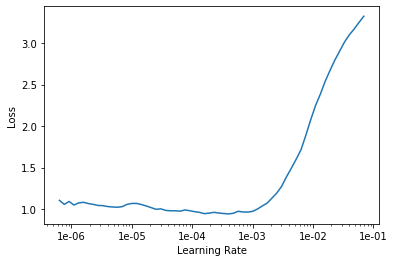

In [39]:
learn.recorder.plot()

Just looking to squeeze it a bit, mainly to use the fine-tuned version to train prototype networks.

In [40]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,f_beta,time
0,0.652490,0.322131,0.903940,1:41:04
1,0.560862,0.309839,0.906326,1:34:20
2,0.475327,0.273707,0.918327,1:19:16
3,0.386535,0.229865,0.931673,1:18:03
4,0.316518,0.195691,0.940634,1:51:21
5,0.259360,0.163346,0.950528,2:13:58
6,0.207169,0.140389,0.957986,2:09:58
7,0.181090,0.122106,0.963761,2:11:09
8,0.124741,0.111168,0.966995,2:18:04
9,0.127082,0.109524,0.967763,2:23:17


Expect results to be something along this line. The model performance basically becomes very good (relatively speaking). The time however to train the epochs are long. 

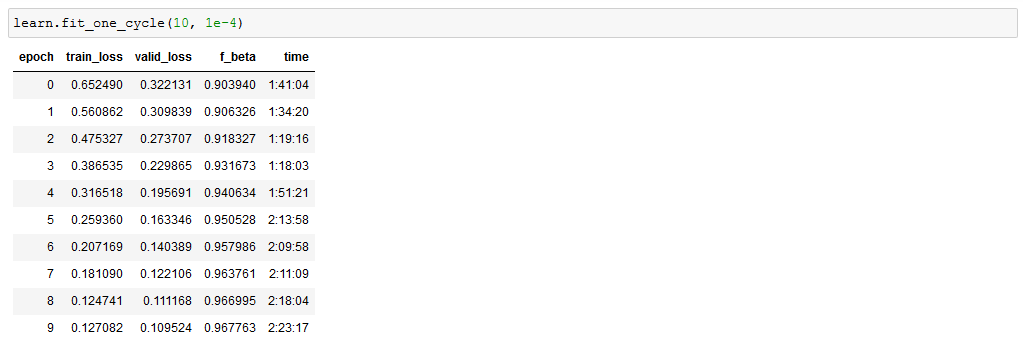

In [42]:
learn.save('herbarium-stage-2-seresnet101')

### draft to load model in plain PyTorch

The trick is to create a replicate fastai model architecture, save model.state_dict() of the fastai model (not using learner.save()) and load state_dict from there for the pytorch model.

In [ ]:
learn.model

In [ ]:
from fastai.layers import Flatten, AdaptiveConcatPool2d

In [ ]:

class Classifier(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()
        self.linear_block=nn.Sequential(#AdaptiveConcatPool2d()
                                        Flatten()
                                        , nn.BatchNorm1d(num_features=2 * input_size)
                                        , nn.Dropout(p=.25)
                                        , nn.Linear(in_features=2 * input_size, out_features=hidden_units, bias=True)
                                        , nn.ReLU(inplace=True)
                                        , nn.BatchNorm1d(num_features=hidden_units)
                                        , nn.Dropout(p=.5)
                                        , nn.Linear(in_features=hidden_units, out_features=output_size, bias=True)
                                        
                                       )
        #self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        #print(x.shape)
        #x = self.pooling(x)
        #x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x
    
def my_head(input_size, hidden_units, output_size):
    return nn.Sequential(AdaptiveConcatPool2d()
                                        , Flatten()
                                        , nn.BatchNorm1d(num_features=2 * input_size)
                                        , nn.Dropout(p=.25)
                                        , nn.Linear(in_features=2 * input_size, out_features=hidden_units, bias=True)
                                        , nn.ReLU(inplace=True)
                                        , nn.BatchNorm1d(num_features=hidden_units)
                                        , nn.Dropout(p=.5)
                                        , nn.Linear(in_features=hidden_units, out_features=output_size, bias=True)
                                        
                                       )

In [ ]:
def _create_layers():
    pretrain = torchvision.models.resnet50(pretrained=True)
    return list([*(pretrain.children())])
arch = nn.Sequential(*_create_layers()[:-2])        

In [ ]:
arch = torchvision.models.resnet50(pretrained=False)
arch = list(arch.children())
arch.pop(-1)
arch.pop(-1)
temp_arch = nn.Sequential(nn.Sequential(*arch))
temp_children = list(temp_arch.children())
temp_children.append(my_head(2048, 512, 100))
model = nn.Sequential(*temp_children)

In [ ]:
model = nn.Sequential(arch, Classifier(512,512,100))

In [ ]:
model

In [ ]:
os.listdir(model_dir + 'models')

In [43]:
model_dir = '/bigdata/user/hieunt124/kaggle/herbarium/nybg2020/train/models/'

In [44]:
torch.save({'state_dict': learn.model.state_dict()}
          , model_dir + 'herbarium-seresnet101-weights.pth'
          )

In [ ]:

#model_file = 'herbarium-resnet50-weights.pth'
#weights = torch.load(model_dir + model_file)
#model.load_state_dict()

In [ ]:
model

In [ ]:
learn.model

In [ ]:
model.load_state_dict(weights['state_dict'])

In [ ]:
type(weights['model'])